In [1]:
from astropy.table import Table
from astropy.io import fits
#from astropy.io import ascii

#from sklearn import neighbors
from sklearn.neighbors import NearestNeighbors

import numpy as np

import sys

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

from scipy import stats
from scipy.integrate import quad

import pickle

import random

# np.set_printoptions(threshold=sys.maxsize)

# Data

In [2]:
#data_filename = 'data_flags_updated_Nov1.dat'
data_filename = '../../../../data/NSA_v1_0_1_VAGC_vflag-V2-VF.fits'

#catalog_SDSS = Table.read(data_filename, format='ascii')
hdu = fits.open(data_filename)
data = Table(hdu[1].data)
hdu.close()

## Just keep the main SDSS DR7 footprint

In [3]:
# When the catalog is the NSA, only keep those objects which were originally in the DR7 LSS
catalog_SDSS = data[data['IN_DR7_LSS'] == 1]

ra_boolean = np.logical_and(catalog_SDSS['RA'] > 110, catalog_SDSS['RA'] < 270)
catalog_north = catalog_SDSS[ra_boolean]

strip_boolean = np.logical_and.reduce([catalog_north['RA'] > 250, 
                                       catalog_north['RA'] < 269, 
                                       catalog_north['DEC'] > 51, 
                                       catalog_north['DEC'] < 67])
catalog_main = catalog_north[~strip_boolean]

## Identify which fields are being used for which parameters

In [5]:
catalog_main.colnames

['IAUNAME',
 'SUBDIR',
 'RA',
 'DEC',
 'ISDSS',
 'INED',
 'ISIXDF',
 'IALFALFA',
 'IZCAT',
 'ITWODF',
 'MAG',
 'Z',
 'ZSRC',
 'SIZE',
 'RUN',
 'CAMCOL',
 'FIELD',
 'RERUN',
 'XPOS',
 'YPOS',
 'NSAID',
 'ZDIST',
 'SERSIC_NMGY',
 'SERSIC_NMGY_IVAR',
 'SERSIC_OK',
 'SERSIC_RNMGY',
 'SERSIC_ABSMAG',
 'SERSIC_AMIVAR',
 'EXTINCTION',
 'SERSIC_KCORRECT',
 'SERSIC_KCOEFF',
 'SERSIC_MTOL',
 'SERSIC_B300',
 'SERSIC_B1000',
 'SERSIC_METS',
 'SERSIC_MASS',
 'XCEN',
 'YCEN',
 'NPROF',
 'PROFMEAN',
 'PROFMEAN_IVAR',
 'QSTOKES',
 'USTOKES',
 'BASTOKES',
 'PHISTOKES',
 'PETRO_FLUX',
 'PETRO_FLUX_IVAR',
 'FIBER_FLUX',
 'FIBER_FLUX_IVAR',
 'PETRO_BA50',
 'PETRO_PHI50',
 'PETRO_BA90',
 'PETRO_PHI90',
 'SERSIC_FLUX',
 'SERSIC_FLUX_IVAR',
 'SERSIC_N',
 'SERSIC_BA',
 'SERSIC_PHI',
 'ASYMMETRY',
 'CLUMPY',
 'DFLAGS',
 'AID',
 'PID',
 'DVERSION',
 'PROFTHETA',
 'PETRO_THETA',
 'PETRO_TH50',
 'PETRO_TH90',
 'SERSIC_TH50',
 'PLATE',
 'FIBERID',
 'MJD',
 'RACAT',
 'DECCAT',
 'ZSDSSLINE',
 'SURVEY',
 'PROGRAMNAME

In [4]:
# ra,dec,z
ra = np.array(catalog_main['RA']) #np.array(data['ra'])
dec = np.array(catalog_main['DEC']) #np.array(data['dec'])
z = np.array(catalog_main['Z']) #np.array(data['redshift'])

# stellar mass
#Mstar = np.array(data['Mstar'])
# Mstar = Mstar[np.logical_not(np.isnan(Mstar))] 
Mstar_NSA = np.log10(catalog_main['ELPETRO_MASS']) #np.array(data['Mstar_NSA'])

# color
u_r = np.array(catalog_main['u_r_KIAS']) #np.array(data['u_r'])
# u_r = u_r[np.logical_not(np.isnan(u_r))]
u_r_NSA = np.array(catalog_main['u_r']) #np.array(data['u_r_NSA'])
#g_r = np.array(data['g_r'])
# g_r = g_r[np.logical_not(np.isnan(g_r))] 
g_r_NSA = np.array(catalog_main['g_r']) #np.array(data['g_r_NSA'])

# absolute magnitude
#rabsmag = np.array(data['rabsmag'])
# rabsmag = rabsmag[np.logical_not(np.isnan(rabsmag))] 
rabsmag_NSA = np.array(catalog_main['ELPETRO_ABSMAG'][:,4]) #np.array(data['rabsmag_NSA'])

#star formation rate and specific SPR
SFR  = np.array(catalog_main['SFR']) #np.array(data['SFR'])
# SFR = SFR[np.logical_not(np.isnan(SFR))] 
sSFR = np.array(catalog_main['sSFR']) #np.array(data['sSFR'])
# sSFR = sSFR[np.logical_not(np.isnan(sSFR))]

/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_1154/912260125.py:9: RuntimeWarning: divide by zero encountered in log10
  Mstar_NSA = np.log10(catalog_main['ELPETRO_MASS']) #np.array(data['Mstar_NSA'])


## Separate galaxies by their LSS classifications

### $V^2$

In [5]:
wall_v2 = catalog_main['vflag_V2'] == 0 #np.argwhere(data['flag_vsquared'] == 0).flatten()
void_v2 = catalog_main['vflag_V2'] == 1 #np.argwhere(data['flag_vsquared'] == 1).flatten()
edge_v2 = catalog_main['vflag_V2'] == 2 #np.argwhere(data['flag_vsquared'] == 2).flatten()
out_v2 = catalog_main['vflag_V2'] == 9 #np.argwhere(data['flag_vsquared'] == 9).flatten()

### VoidFinder

In [6]:
wall_vf = catalog_main['vflag_VF'] == 0 #np.argwhere(data['flag_voidfinder'] == 0).flatten()
void_vf = catalog_main['vflag_VF'] == 1 #np.argwhere(data['flag_voidfinder'] == 1).flatten()
edge_vf = catalog_main['vflag_VF'] == 2 #np.argwhere(data['flag_voidfinder'] == 2).flatten()
out_vf = catalog_main['vflag_VF'] == 9 #np.argwhere(data['flag_voidfinder'] == 9).flatten()

# Result plots

In [7]:
def char_void(char_, bins_, title='galaxy property', label='x-label'):
    '''
    Plots a histogram for a galaxy characterstic for void galaxies only 
    for both algorithms
    
    PARAMETERS
    ==========
    
    char_ : (numpy array)
        charachteristic of galaxy desired for plotting
    
    bins_ : (numpy linear space) 
        histogram bins
    '''
    char_void_vf = char_[void_vf]
    char_void_v2 = char_[void_v2]
    
    fig, ax = plt.subplots(figsize=(10, 6)) # 8,4
    
#     plt.hist(char_void_vf, label = 'Voidfinder void galaxies' ,bins= bins_,alpha = 0.6, density = True, color='green')
#     plt.hist(char_void,  label = 'V^2 void galaxies',bins= bins_, color = 'blue',alpha = 0.4, density = True)
#     plt.hist(char_[data['redshift']< 0.1026],  label = 'All galaxies',bins= bins_, color = 'gray',alpha = 0.6, density = True)

#     plt.legend()
#     plt.title(title)
#     plt.xlabel(label)    
    
#     plt.savefig('figures/'+title+".png")
#     plt.show()
    
    
    counts_void_vf, bins_void_vf = np.histogram(char_void_vf, bins= bins_)
    counts_void_v2, bins_void_v2 = np.histogram(char_void_v2, bins= bins_)
    counts_all, bins_all = np.histogram(char_[catalog_main['Z']< 0.1114], bins= bins_)
    
    counts_void_vf = np.array(counts_void_vf)/len(char_void_vf)
    counts_void_v2 = np.array(counts_void_v2)/len(char_void_v2)
    counts_all = np.array(counts_all)/len(char_[catalog_main['Z']< 0.1114])
    
    ax.hist(bins_void_vf[:-1], 
            bins=bins_void_vf, 
            weights=counts_void_vf, 
            label = 'Voidfinder void galaxies' , 
            color='red', 
            histtype='step')
    ax.hist(bins_void_v2[:-1], 
            bins=bins_void_v2, 
            weights=counts_void_v2,
            label = r'$V^{2}$ void galaxies', 
            color = 'blue',
            histtype='step')
    ax.hist(bins_all[:-1], 
            bins=bins_all, 
            weights=counts_all, 
            label = 'All', 
            color = 'gray',
            alpha = 0.2)
    
    
    ax.legend(fontsize=14)
#     plt.title(title, fontsize=18)
    ax.set_xlabel(label, fontsize=20)
    ax.set_ylabel(r"Fraction of galaxies", fontsize=20)
    
    if label == 'Absolute Magnitude' or label == 'Absolute Magnitude - NSA':
        ax.set_xlim(-12, -24) 
        
#     plt.savefig('figures/'+title+".png")
#     plt.show()

In [8]:
def char(char_, 
         bins_, 
         title='galaxy property', 
         label='x-label', 
         voidfinder=False,
         x=None,
         y=None):
    '''
    Plots a histogram for a galaxy characterstic for wall and void galaxies
    
    PARAMETERS
    ==========
    
    char_ : (numpy array)
        charachteristic of galaxy desired for plotting
    
    bins_ : (numpy linear space)
        histogram bins
    
    voidfinder : (bool) 
        True if the classification comes from the VoidFinder algorithm, 
        False if it comes from V^2
    
    x : 
        x coordinate of the location of the algorithm's name
    
    y :
        y coordinate of the location of the algorithm's name
    '''
    
    if voidfinder:
        char_wall = char_[wall_vf]
        char_void = char_[void_vf]
#         char_edge = char_[edge_vf]
#         char_out = char_[out_vf]
        x_vf=x
        y_vf=y
    else:
        char_wall = char_[wall_v2]
        char_void = char_[void_v2]
#         char_edge = char_[edge_v2]
#         char_out = char_[out_v2]
        x_v2=x
        y_v2=y
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.tick_params(labelsize=20)
    
    counts_wall, bins_wall = np.histogram(char_wall, bins= bins_)
    counts_void, bins_void = np.histogram(char_void, bins= bins_)
    
#     counts_edge, bins_edge = np.histogram(char_edge, bins= bins_)
#     counts_out, bins_out = np.histogram(char_out, bins= bins_)
    
    counts_all, bins_all = np.histogram(char_[catalog_main['Z']< 0.114], 
                                        bins= bins_)
    
    
    counts_wall = np.array(counts_wall)/len(char_wall)
    counts_void = np.array(counts_void)/len(char_void)
#     counts_edge, counts_out = np.array(counts_edge)/len(char_edge), np.array(counts_out)/len(char_out)
    counts_all = np.array(counts_all)/len(char_[catalog_main['Z']< 0.114])
    
    '''
    if voidfinder:
        color_wall='black'
        color_void='red'
    else:
        color_wall='blue'
        color_void='green'
    '''
    color_wall = 'black'
    color_void = 'red'
    
    ax.hist(bins_void[:-1], 
            bins=bins_void, 
            weights=counts_void ,
            label = 'Void', 
            color = color_void,
            histtype='step', 
            linewidth=2)
    ax.hist(bins_wall[:-1], 
            bins=bins_wall, 
            weights=counts_wall, 
            label = 'Wall' , 
            color=color_wall, 
            histtype='step',
            linestyle='dotted', 
            linewidth=2)
    
#     ax.hist(bins_edge[:-1], bins=bins_edge, weights=counts_edge ,label = 'Edge', color = 'green',histtype='step')
#     ax.hist(bins_out[:-1], bins=bins_out, weights=counts_out ,label = 'Out', color = 'purple',histtype='step')

    ax.hist(bins_all[:-1], 
            bins=bins_all, 
            weights=counts_all,  
            label = 'All', 
            color = 'gainsboro', 
            ec='gainsboro')
    
#     if (voidfinder == True) & (x!= None):
#         ax.text(x_vf, y_vf, "VoidFinder", fontsize=20)
#     if (voidfinder == False) & (x!= None):
#         ax.text(x_v2, y_v2, r'\boldmath$V^{2}$', fontsize=20)
    
    ax.legend(fontsize=18)
    ax.set_xlabel(label, fontsize=24)
    ax.set_ylabel(r"Fraction of galaxies", fontsize=24)
    
#     plt.title(title, fontsize=18)
    if voidfinder:
        ax.set_title('VoidFinder', fontsize=24)
    else:
        ax.set_title('$V^2$', fontsize=24)
    
    if label in ['Absolute Magnitude', 'Absolute Magnitude - NSA', '$M_r$']:
        ax.set_xlim(-12, -24)
        
    plt.tight_layout()
    
    plt.savefig('figures/'+title+".eps", format='eps', dpi=300)
#     plt.show()

- make axis ticks numbers larger , "at least" as large as the figure caption
- try different bin sizes , widen a little? double?
- Wall line = dashed / try filling both wall and void / line size on wall thicker than line size in void -- distinguish in Black white
- axis limits to where data is
- should we include CDFs? maybe not (no KS)
- color and linestyle for each class (V2 wall, void , VF void, wall) = 4 colors, 2 linestyles
- Msun - $M_{\odot}$ , Mstar
- log Mstar/Mdot aboe
- unbold axis titles
- serif font , same font throughout plot
- x,y axis ranges accross parameters
- save in eps

## Stellar mass

In [9]:
# np.linspace(5.9,12, 155)[-1]-np.linspace(5.9,12, 135)[-2]

In [10]:
# char(Mstar,np.linspace(5.9,12, 135),r'Star Mass - Voidfinder',r'$\log(M_*/M_\odot)$', voidfinder = True,x=6,y=0.025)
# char(Mstar,np.linspace(5.9,12, 135),r'Star Mass - Voidfinder',r'$\log(M_*/M_\odot)$',x=6,y=00.025)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


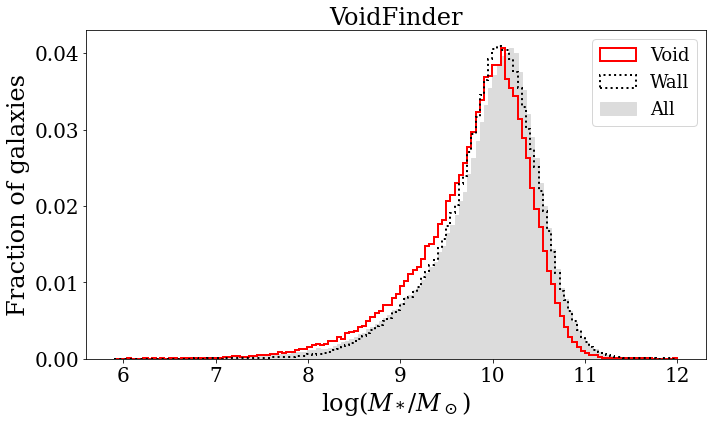

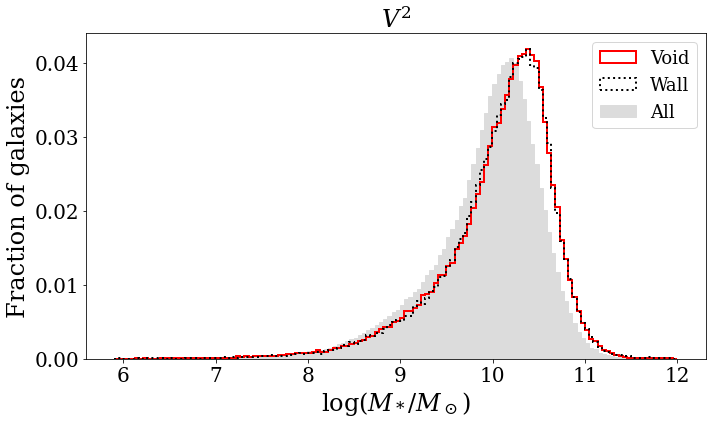

In [11]:
# char_inside(Mstar,np.linspace(5.5,12.5, 250),len(ind_gal_depth_voidv2_new),r'\textbf{Star Mass - }\boldmath${V^{2}}$',r'\boldmath$M_{star} [ log(M_{sun}) ]$',x=6,y=0.019)
# char(Mstar,np.linspace(5.9,12, 135),r'Star Mass - Voidfinder',r'$\log(M_*/M_\odot)$', voidfinder = True,x=6,y=0.025)
char(Mstar_NSA,
     np.linspace(5.9,12, 135),
     'Mstar_hist_VF_NSA',
     r'$\log(M_*/M_\odot)$',
     voidfinder=True,
     x=6,
     y=0.025)
char(Mstar_NSA,
     np.linspace(5.9,12, 135),
     'Mstar_hist_V2_NSA',
     r'$\log(M_*/M_\odot)$',
     x=6,
     y=0.025)

# char(np.log10(Mstar_NSA),np.linspace(5.9,12, 135),r'Star Mass - Voidfinder',r'$\log(M_*/M_\odot)$',voidfinder=True,x=6,y=00.025)
# char(np.log10(Mstar_NSA),np.linspace(5.9,12, 135),r'Star Mass - Voidfinder',r'$\log(M_*/M_\odot)$',x=6,y=00.025)

# char_void(Mstar,np.linspace(5.5,12.5, 250),'Star Mass - void galaxies',r'\boldmath$Mstar [log(M_{sun})]$')
# CDF(Mstar,np.linspace(5.5,12.5, 700),'Cumulative Star Mass',r'\boldmath$Mstar [log(M_{sun})]$')



#### Stellar Mass - NSA

In [12]:
# char(np.log10(Mstar_NSA),np.linspace(5.5,12.5, 250),r'\textbf{Star Mass NSA - }\boldmath$V^{2}$',r'\boldmath$M_{star-NSA} [log(M_{sun})]$',x=6,y=0.0055)
# char(np.log10(Mstar_NSA),np.linspace(5.5,12.5, 250),'$Star Mass_{NSA} - VoidFinder$',r'\boldmath$M_{star-NSA} [log(M_{sun})]$', voidfinder = True,x=6,y=0.0055)
# char_void(np.log10(Mstar_NSA),np.linspace(5.5,12.5, 250),'$Star Mass_{NSA}- void galaxies$',r'\boldmath$M_{star-NSA} [log(M_{sun})]$')
# CDF(np.log10(Mstar_NSA),np.linspace(5.5,12.5, 700),'$Cumulative Star Mass_{NSA}$',r'\boldmath$M_{star-NSA} [log(M_{sun})]$')

## Color

### $u-r$

- make axis ticks numbers larger , "at least" as large as the figure caption
- try different bin sizes , widen a little? double?
- Wall line = dashed / try filling both wall and void / line size on wall thicker than line size in void -- distinguish in Black white
- axis limits to where data is
- should we include CDFs? maybe not (no KS)
- color and linestyle for each class (V2 wall, void , VF void, wall) = 4 colors, 2 linestyles
- unbold axis titles
- serif font , same font throughout plot
- x,y axis ranges accross parameters
- save in eps

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


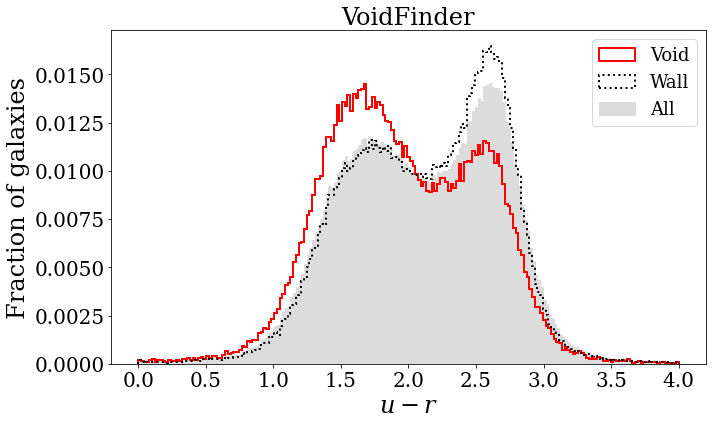

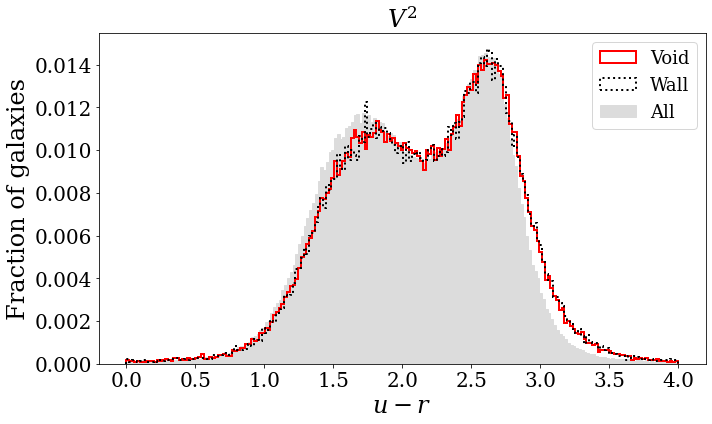

In [13]:
# char(u_r,np.linspace(0,4, 200),'Color u_r - V^2',r'\boldmath$u-r$',x=0.2,y=0.016)
char(u_r_NSA, 
     np.linspace(0,4, 200),
     'u-r_hist_VF_NSA',
     r'$u-r$', 
     voidfinder = True,
     x=0.2,
     y=0.016)
char(u_r_NSA, 
     np.linspace(0,4, 200),
     'u-r_hist_V2_NSA',
     r'$u-r$', 
     x=0.2,
     y=0.016)
# char_void(u_r,np.linspace(0,4, 500),'Color u_r - void galaxies',r'\boldmath$u-r$')
# CDF(u_r,np.linspace(0,4, 700),'Cumulative Color u_r',r'\boldmath$u-r$')


#### Color u-r - NSA

The conclusions from VF are in line with the literature that indicates that void galaxies are retarded in their star formation because they evolve in an environment with fewer interactions (mergers, tidal stripping etc) compared to wall galaxies.

$V^2$ does not make the same prediction because it grows voids farther into the walls which leads to the contamination of the classification

In [14]:
# char(u_r_NSA,np.linspace(-1,4, 250),'Color u_r V^2',r'\boldmath$u-r$ \textrm{(NSA)}',x=-0.5,y=0.005)
# char(u_r_NSA,np.linspace(-1,4, 250),'Color u_r-NSA- Voidfinder',r'\boldmath$u-r$ \textrm{(NSA)}', voidfinder = True,x=-0.5,y=0.0055)
# char_void(u_r_NSA,np.linspace(-1,4, 250),'Color u_r -NSA- void galaxies',r'\boldmath$u-r$ \textrm{(NSA)}')
# CDF(u_r_NSA,np.linspace(-1,4, 700),'Cumulative Color u_r-NSA',r'\boldmath$u-r$ \textrm{(NSA)}')

### $g-r$ 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


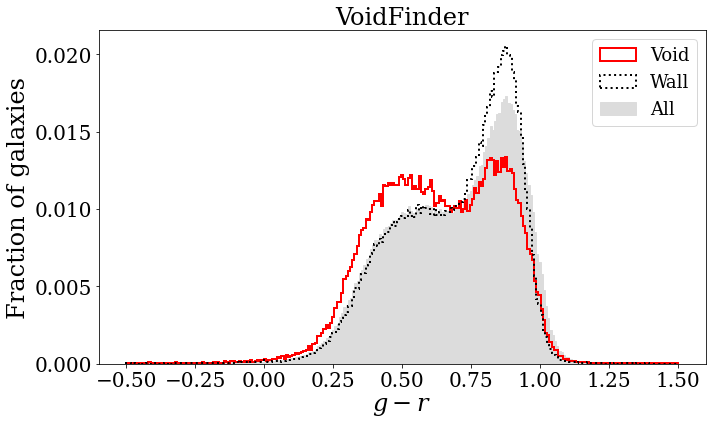

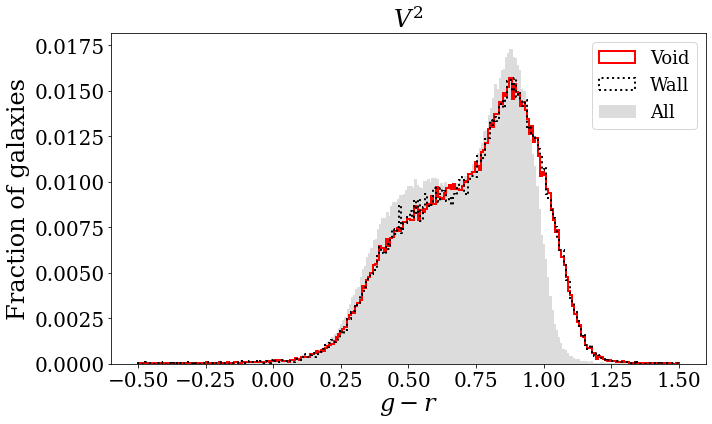

In [15]:
# char_inside(g_r,np.linspace(-0.5,1.5, 250),'Color g_r - V^2',r'\boldmath$g-r$',x=-0.35,y=0.025)
char(g_r_NSA, 
     np.linspace(-0.5,1.5, 250),
     'g-r_hist_VF_NSA',
     r'$g-r$', 
     voidfinder = True,
     x=0.2,
     y=0.016)
char(g_r_NSA, 
     np.linspace(-0.5,1.5, 250),
     'g-r_hist_V2_NSA',
     r'$g-r$', 
     x=0.2,
     y=0.016)
# char(g_r,np.linspace(-0.5,1.5, 250),'Color g_r - Voidfinder',r'\boldmath$g-r$', voidfinder = True,x=-0.35,y=0.025)
# char_void(g_r,np.linspace(-0.5,1.5, 250),'Color g_r - void galaxies',r'\boldmath$g-r$')
# CDF(g_r,np.linspace(-0.5,1.5, 700),'Cumulative Color g_r',r'\boldmath$g-r$')

#### Color g-r - NSA

In [16]:
# char(g_r_NSA,np.linspace(-0.5,1.3, 250),'Color g_r-NSA - V^2',r'\boldmath$g-r$ \textrm{(NSA)}',x=-0.35,y=0.0055)
# char(g_r_NSA,np.linspace(-0.5,1.3, 250),'Color g_r-NSA - Voidfinder',r'\boldmath$g-r$ \textrm{(NSA)}', voidfinder = True,x=-0.35,y=0.005)
# char_void(g_r_NSA,np.linspace(-0.5,1.3, 250),'Color g_r -NSA- void galaxies',r'\boldmath$g-r$ \textrm{(NSA)}')
# CDF(g_r_NSA,np.linspace(-0.5,1, 700),'Cumulative Color g_r-NSA',r'\boldmath$g-r$ \textrm{(NSA)}')

## Absolute magnitude

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


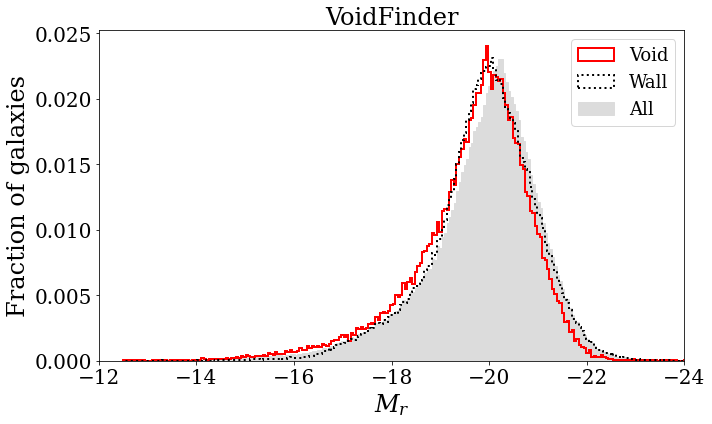

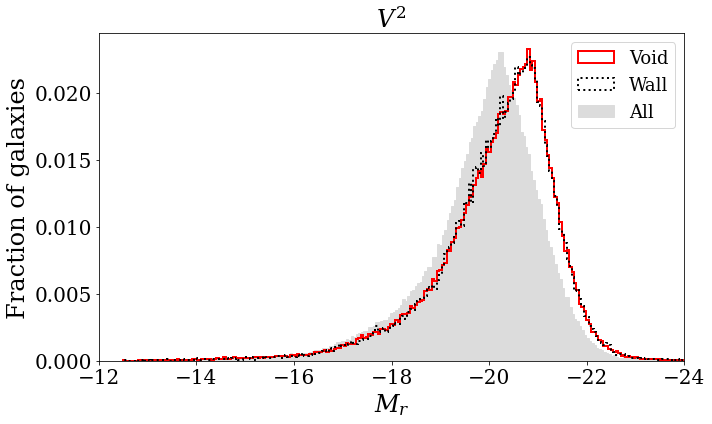

In [17]:
# char_inside(rabsmag,np.linspace(-25,-12.5, 250),'Absolute Magnitude - V^2','Absolute Magnitude',x=-13,y=0.023)
char(rabsmag_NSA,
     np.linspace(-25,-12.5, 250),
     'rabsmag_hist_VF_NSA',
     '$M_r$', 
     voidfinder=True,
     x=-13,
     y=0.023)
char(rabsmag_NSA,
     np.linspace(-25,-12.5, 250),
     'rabsmag_hist_V2_NSA',
     '$M_r$',
     x=-13,
     y=0.023)
# char_void(rabsmag,np.linspace(-25,-12.5, 250),'Absolute Magnitude- void galaxies','Absolute Magnitude')
# CDF(rabsmag,np.linspace(-25,-12.5, 700),'Cumulative Absolute Magnitude','Absolute Magnitude')

#### Absolute magnitude - NSA

In [18]:
'''
# char_inside(rabsmag,np.linspace(-25,-12.5, 250),'Absolute Magnitude - V^2','Absolute Magnitude',x=-13,y=0.023)
char(rabsmag_NSA,np.linspace(-25,-12.5, 250),'Absolute Magnitude - Voidfinder','Absolute Magnitude', voidfinder = True,x=-13,y=0.023)
char(rabsmag_NSA,np.linspace(-25,-12.5, 250),'Absolute Magnitude - Vsquared','Absolute Magnitude',x=-13,y=0.023)
# char_void(rabsmag,np.linspace(-25,-12.5, 250),'Absolute Magnitude- void galaxies','Absolute Magnitude')
# CDF(rabsmag,np.linspace(-25,-12.5, 700),'Cumulative Absolute Magnitude','Absolute Magnitude')
''';

## Star Formation Rate

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


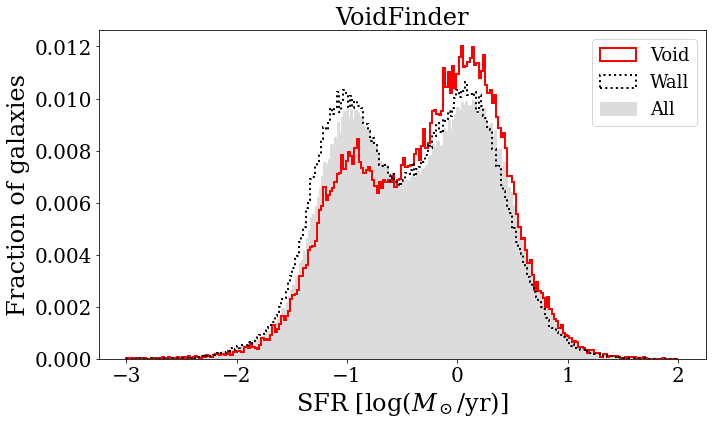

In [19]:
# char_inside(SFR,np.linspace(-3,2, 250),'star formation rate - V^2','SFR [log(Msun/yr)]',x=-2.7,y=0.0105)
char(SFR,
     np.linspace(-3,2, 250),
     'SFR_hist_VF_NSA',
     'SFR [log($M_\odot$/yr)]', 
     voidfinder = True,
     x=-2.7,
     y=0.012)
# char_void(SFR,np.linspace(-3,2, 250),'star formation rate- void galaxies','SFR [log(Msun/yr)]')
# CDF(SFR,np.linspace(-3,2, 700),'Cumulative star formation rate','SFR [log(Msun/yr)]')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


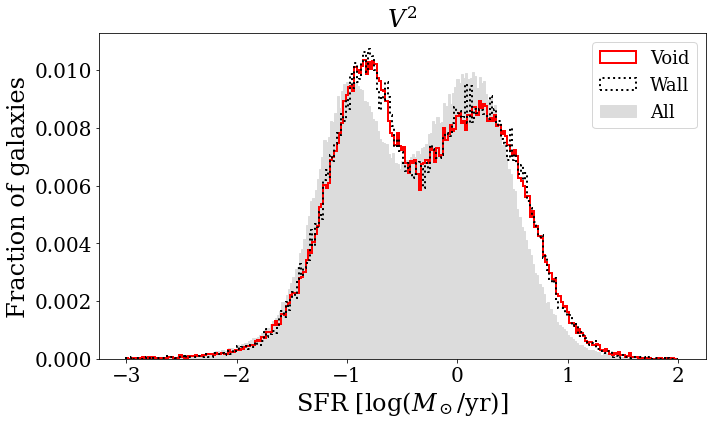

In [20]:
char(SFR,
     np.linspace(-3,2, 250),
     'SFR_hist_V2_NSA',
     'SFR [log($M_\odot$/yr)]',
     x=-2.7,
     y=0.0105)
#char(SFR,np.linspace(-3,2, 250),'star formation rate - Voidfinder','SFR [log(Msun/yr)]', voidfinder = True,x=-2.7,y=0.012)
#char_void(SFR,np.linspace(-3,2, 250),'star formation rate- void galaxies','SFR [log(Msun/yr)]')
#CDF(SFR,np.linspace(-3,2, 700),'Cumulative star formation rate','SFR [log(Msun/yr)]')

## Specific Star Formation Rate

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


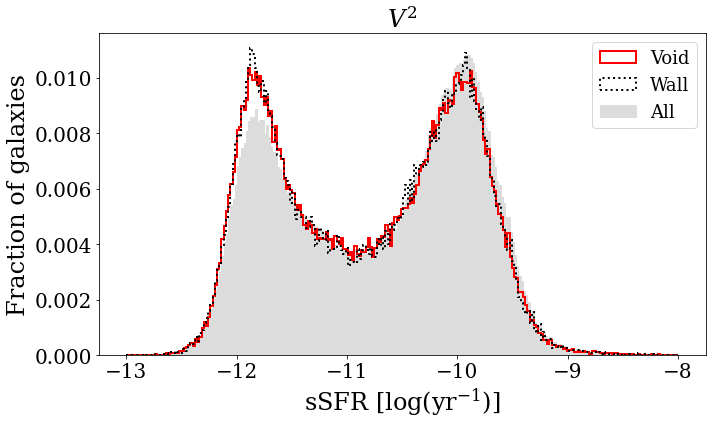

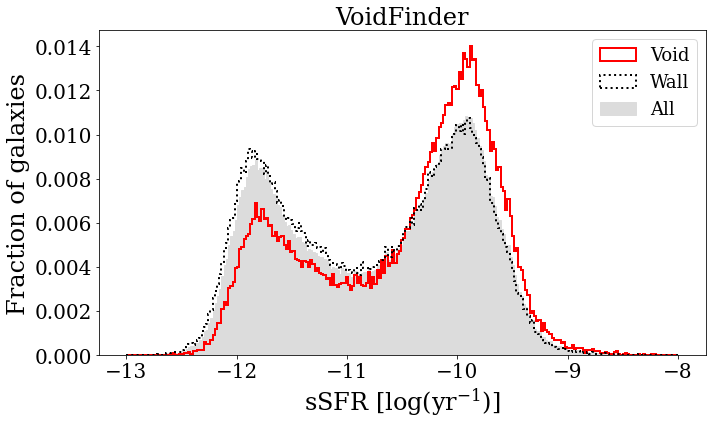

In [21]:
char(sSFR,
     np.linspace(-13,-8, 250),
     'sSFR_hist_V2_NSA',
     'sSFR [log(yr$^{-1}$)]',
     x=-12.7,
     y=0.0105)
char(sSFR,
     np.linspace(-13,-8, 250),
     'sSFR_hist_VF_NSA',
     'sSFR [log(yr$^{-1}$)]', 
     voidfinder = True,
     x=-12.7,
     y=0.013)
#char_void(sSFR,np.linspace(-13,-8, 250),'specific star formation rate- void galaxies','sSFR [log(1/yr)] ')
#CDF(sSFR,np.linspace(-13,-8, 700),'Cumulative specific star formation rate','sSFR [log(1/yr)] ')

# KS tests

We no longer use these in favor of the Beysian analysis.

In [31]:
def KS(char_, void_void=False,void_wall=False,wall_wall=False,voidfinder=False,v2=False):
    '''
    char_: array of galaxy property
    void_void: True if we want to calculate the KS test between two void galaxy samples
    void_wall: True if we want to calculate the KS test between void and wall galaxy samples
    voidfinder : True only if void_wall is True and classification from voidfinder is used
    '''
    #void_wall
    if (void_wall and voidfinder):
        return stats.ks_2samp(char_[wall_vf], char_[void_vf]) 
    if (void_wall and v2):
        return stats.ks_2samp(char_[wall_v2], char_[void_v2]) 
    
    #void_void
    if void_void:
        return stats.ks_2samp(char_[void_vf], char_[void_v2]) 

    # wall_wall
    if wall_wall:
        return stats.ks_2samp(char_[wall_vf], char_[wall_v2]) 



In [35]:
def KS_table(char_):
    '''
    output: two numbers for each cell: kS Test statistic and p-value
    
    diagonals are void_void and wall_wall, row2col1 is void_wall for voidfinder,  and row1col2 is void_wall for V^2
    '''
    a_1_1 = tuple(KS(char_,void_void=True)) #1_1
    a_2_1 = tuple(KS(char_,void_wall=True,voidfinder=True))

    a_1_2 = tuple(KS(char_,void_wall=True,v2=True))
    a_2_2 = tuple(KS(char_,wall_wall=True)) 

    col1=[a_1_1,a_2_1]
    
    col2=[a_1_2,a_2_2]
    

    
    return Table([col1,col2], names=('voidfinder','v_squared'))


In [56]:
print(stats.ks_2samp(Mstar[void_vf], Mstar[wall_v2]) )
print(stats.ks_2samp(u_r[void_vf], u_r[wall_v2]) )
print(stats.ks_2samp(g_r[void_vf], g_r[wall_v2]) )
print(stats.ks_2samp(rabsmag[void_vf], rabsmag[wall_v2]) )
print(stats.ks_2samp(SFR[void_vf], SFR[wall_v2]) )
print(stats.ks_2samp(sSFR[void_vf], sSFR[wall_v2])) 

Ks_2sampResult(statistic=0.09737432984377059, pvalue=9.596518308845177e-277)
Ks_2sampResult(statistic=0.0974511063843424, pvalue=3.517261688586993e-277)
Ks_2sampResult(statistic=0.09735619756826153, pvalue=1.2162194642940036e-276)
Ks_2sampResult(statistic=0.06347187632710183, pvalue=7.88210948369142e-118)
Ks_2sampResult(statistic=0.09303149284014245, pvalue=1.2017203629488489e-252)
Ks_2sampResult(statistic=0.08821650698776451, pvalue=3.253512720093948e-227)


In [59]:
print(stats.ks_2samp(Mstar[wall_v2], Mstar[wall_vf]) )
print(stats.ks_2samp(u_r[wall_v2], u_r[wall_vf]) )
print(stats.ks_2samp(g_r[wall_v2], g_r[wall_vf]) )
print(stats.ks_2samp(rabsmag[wall_v2], rabsmag[wall_vf]) )
print(stats.ks_2samp(SFR[wall_v2], SFR[wall_vf]) )
print(stats.ks_2samp(sSFR[wall_v2], sSFR[wall_vf])) 

Ks_2sampResult(statistic=0.06905365180479675, pvalue=0.0)
Ks_2sampResult(statistic=0.04061800208835664, pvalue=1.0664370213578124e-116)
Ks_2sampResult(statistic=0.04387652575658352, pvalue=4.2065027361769384e-136)
Ks_2sampResult(statistic=0.09127565178886077, pvalue=0.0)
Ks_2sampResult(statistic=0.03518965229369064, pvalue=1.0705447985007178e-87)
Ks_2sampResult(statistic=0.036294646464199665, pvalue=2.9021058099386363e-93)


In [44]:
KS_table(sSFR)

voidfinder [2],v_squared [2]
float64,float64
0.11063584061143517 .. 0.0,0.03529738868550192 .. 1.2314651729235756e-85
0.1204748760652663 .. 0.0,0.036294646464199665 .. 2.9021058099386363e-93


In [774]:
#void-void      void-wall-v2
#void-wall-vf   wall-wall

In [775]:
# decide how to interpret KS test, compare to critical value, p-value? ...

In [776]:
def critical_value(n,m,alpha=0.000000000000000000000000000000000000000001):
    '''
    calculates critical value: if the test statistic is larger than this then the null hypothesis can be rejected 
    at level alpha.
    n: size of sample 1
    m: size of sample 2
    '''
    
    return np.sqrt(-np.log(alpha/2)*(1/2))*np.sqrt((n+m)/(n*m))

In [595]:
critical_value(len(Mstar[wall_vf]),len(Mstar[void_vf])), critical_value(len(Mstar[wall_v2]),len(Mstar[void_v2]))

(0.035894099904138624, 0.02486973838113133)

In [583]:
critical_value(len(Mstar[data['redshift']< 0.1026]),len(Mstar[void_vf])), critical_value(len(Mstar[data['redshift']< 0.1026]),len(Mstar[void_v2]))

(0.006748918330462532, 0.003741446596947954)

In [ ]:
#next: understand hypothesis testing, what does it mean for the hypothesis to be rejected the X% level?
# write statistics paragraph for stellar mass

# Calculate averages and medians

In [22]:
def remove_nan(array):
    '''
    Remove both nan and inf values from array
    '''
    #return array[np.logical_not(np.isnan(array))]
    return array[np.isfinite(array)]

In [23]:
def stats(char_,voidfinder=False):
    '''
    char : array with galaxy properties e.g : Mstar
    voidfinder : true if we want to calculate the statistics of voidfinder data and not V^2 data
    
    note 1 : shifts are taken as void-wall
    note 2: percent difference are calculated with respect to the wall distribution
    
    returns: average, std of average, average shift, std of average shift, percent diff of avg , median, median shift, 
    percent diff of median
    '''
    if voidfinder:
        char_void = remove_nan(char_[void_vf])
        char_wall = remove_nan(char_[wall_vf])
    else:
        char_void = remove_nan(char_[void_v2])
        char_wall = remove_nan(char_[wall_v2])
        
    avg_void = np.mean(char_void)
    avg_wall = np.mean(char_wall)
        
    avg_shift=  avg_wall-avg_void
        
    std_avg_void = np.std(char_void,ddof=1)/np.sqrt(len(char_void))
    std_avg_wall = np.std(char_wall,ddof=1)/np.sqrt(len(char_wall))
    
    std_avg_shift = np.sqrt(std_avg_void**2 + std_avg_wall**2)
        
    percent_diff_avg = (avg_shift/avg_wall)*100
    
    median_wall = np.median(char_wall)
    median_void = np.median(char_void)
    
    median_shift = median_wall-median_void
    
    percent_diff_median = (median_shift/median_wall)*100
    
    print('average void : %f +- %f' %(avg_void, std_avg_void))
    print('average wall :  %f +- %f'%(avg_wall, std_avg_wall))
    print('average shift w.r.t wall :  %f +- %f'%(avg_shift, std_avg_shift))
    print('percent difference in avg w.r.t wall : ', percent_diff_avg)
    print('median void : ', median_void)
    print('median wall : ', median_wall)
    print('median shift w.r.t wall: ', median_shift)
    print('percent difference in median w.r.t wall : ', percent_diff_median)

In [24]:
stats(Mstar_NSA, voidfinder=True)

average void : 9.791948 +- 0.002144
average wall :  9.938634 +- 0.001217
average shift w.r.t wall :  0.146686 +- 0.002465
percent difference in avg w.r.t wall :  1.4759130775928497
median void :  9.914782
median wall :  10.0156555
median shift w.r.t wall:  0.10087395
percent difference in median w.r.t wall :  1.0071626864373684


In [25]:
stats(Mstar_NSA)

average void : 10.049424 +- 0.001814
average wall :  10.053588 +- 0.002489
average shift w.r.t wall :  0.004164 +- 0.003080
percent difference in avg w.r.t wall :  0.04141548415645957
median void :  10.178245
median wall :  10.17561
median shift w.r.t wall:  -0.0026350021
percent difference in median w.r.t wall :  -0.02589527575764805


In [26]:
stats(rabsmag_NSA, voidfinder=True)

average void : -19.630388 +- 0.004328
average wall :  -19.859749 +- 0.002472
average shift w.r.t wall :  -0.229361 +- 0.004984
percent difference in avg w.r.t wall :  1.1549017392098904
median void :  -19.844994
median wall :  -19.960026
median shift w.r.t wall:  -0.115032196
percent difference in median w.r.t wall :  0.5763128399848938


In [27]:
stats(rabsmag_NSA)

average void : -20.132048 +- 0.003797
average wall :  -20.140867 +- 0.005208
average shift w.r.t wall :  -0.008820 +- 0.006445
percent difference in avg w.r.t wall :  0.0437894748756662
median void :  -20.368385
median wall :  -20.361034
median shift w.r.t wall:  0.0073509216
percent difference in median w.r.t wall :  -0.036102888407185674


In [28]:
stats(u_r_NSA, voidfinder=True)

average void : 1.964827 +- 0.002019
average wall :  2.126714 +- 0.001260
average shift w.r.t wall :  0.161887 +- 0.002380
percent difference in avg w.r.t wall :  7.6120786850142
median void :  1.9200235605239868
median wall :  2.1748095005750656
median shift w.r.t wall:  0.2547859400510788
percent difference in median w.r.t wall :  11.71532219183832


In [29]:
stats(u_r_NSA)

average void : 2.173175 +- 0.001807
average wall :  2.181889 +- 0.002525
average shift w.r.t wall :  0.008715 +- 0.003105
percent difference in avg w.r.t wall :  0.3994041708071214
median void :  2.209872081875801
median wall :  2.216634824872017
median shift w.r.t wall:  0.00676274299621582
percent difference in median w.r.t wall :  0.3050905327451167


In [30]:
stats(g_r_NSA, voidfinder=True)

average void : 0.629813 +- 0.000863
average wall :  0.687793 +- 0.000502
average shift w.r.t wall :  0.057980 +- 0.000999
percent difference in avg w.r.t wall :  8.429834011013785
median void :  0.6351367756724358
median wall :  0.7326488941907883
median shift w.r.t wall:  0.09751211851835251
percent difference in median w.r.t wall :  13.309529201713296


In [31]:
stats(g_r_NSA)

average void : 0.731778 +- 0.000745
average wall :  0.733455 +- 0.001012
average shift w.r.t wall :  0.001677 +- 0.001256
percent difference in avg w.r.t wall :  0.22859561321794344
median void :  0.7706251367926598
median wall :  0.7719283923506737
median shift w.r.t wall:  0.001303255558013916
percent difference in median w.r.t wall :  0.1688311468950179


In [32]:
stats(sSFR, voidfinder=True)

average void : -10.493957 +- 0.002961
average wall :  -10.756806 +- 0.001980
average shift w.r.t wall :  -0.262849 +- 0.003561
percent difference in avg w.r.t wall :  2.4435572637919876
median void :  -10.237500190734863
median wall :  -10.624045848846436
median shift w.r.t wall:  -0.38654565811157227
percent difference in median w.r.t wall :  3.6384035198186155


In [33]:
stats(sSFR)

average void : -10.786401 +- 0.002643
average wall :  -10.786955 +- 0.003663
average shift w.r.t wall :  -0.000554 +- 0.004517
percent difference in avg w.r.t wall :  0.005133508610110206
median void :  -10.681559562683105
median wall :  -10.672304153442383
median shift w.r.t wall:  0.009255409240722656
percent difference in median w.r.t wall :  -0.08672362694739445


In [34]:
stats(SFR, voidfinder=True)

average void : -0.301840 +- 0.002358
average wall :  -0.434024 +- 0.001520
average shift w.r.t wall :  -0.132184 +- 0.002806
percent difference in avg w.r.t wall :  30.455446437013382
median void :  -0.2150493711233139
median wall :  -0.4153149724006653
median shift w.r.t wall:  -0.20026560127735138
percent difference in median w.r.t wall :  48.220173744217895


In [35]:
stats(SFR)

average void : -0.314452 +- 0.002135
average wall :  -0.314472 +- 0.002941
average shift w.r.t wall :  -0.000020 +- 0.003634
percent difference in avg w.r.t wall :  0.006504562647369105
median void :  -0.323418065905571
median wall :  -0.32138708233833313
median shift w.r.t wall:  0.002030983567237854
percent difference in median w.r.t wall :  -0.6319431236815489
